In [139]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

from trading.exchange import BackTestExchange
from trading.dataManager import CurrencyDataManager
from trading.money.contract import ContractPair, Contract
from trading.statistics import Statistics

# Load Data

In [64]:
usdtBtc = pd.read_csv('data/USDT-BTC_15min_2016-01-01_2017-11-28.tsv', sep='\t')
usdtBtcManager = CurrencyDataManager(usdtBtc)
wallet = {'usdt': 1000}
exchange = BackTestExchange(usdtBtcManager, wallet, 0.0035)
dataManager = usdtBtcManager
contractPair = ContractPair('usdt', 'btc')

# Simple Moving Average

In [99]:
from copy import deepcopy

class SimpleMAStrategy:
    def __init__(self, exchange, dataManager, timePeriod, contractPair, opened=False):
        self.exchange = deepcopy(exchange)
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = deepcopy(dataManager)
        self.timePeriod = timePeriod
        self.contractPair = contractPair
        self.opened = opened
    
    def calculateMA(self, history, col):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': self.timePeriod})[-1]
    
#     def shoulBuy(self, history, price)
    
    
    def trade(self):
        while self.dataManager.hasTick():
            history, price = self.dataManager.tick(self.timePeriod)
            if history.shape[0] < self.timePeriod:
                continue

            maClose = self.calculateMA(history, 'close')

            if not self.opened and price > maClose:
                amount = (0.1 * self.exchange.balance(self.contractPair.priceContract)) / price  
                self.exchange.buy(self.contractPair, amount, price)
                self.opened = True
            elif self.opened and price < maClose:
                self.opened = False
                amount = self.exchange.balance(self.contractPair.tradeContract)
                self.exchange.sell(self.contractPair, amount, price)
                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)
        

In [128]:
import time

allStats = None
for timePeriod in range(96, 96*30, 96):
    start_time = time.time()
    print('timePeriod:', timePeriod, end=' ')
    simpleMA = SimpleMAStrategy(exchange, usdtBtcManager, timePeriod, contractPair)
    simpleMA.trade()
    stats = simpleMA.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
    stats['timePeriod'] = timePeriod
    if allStats is None:
        allStats = stats
    else:
        allStats = allStats.append(stats)
    print("--- %s seconds ---" % (time.time() - start_time))

timePeriod: 96 --- 18.415167570114136 seconds ---
timePeriod: 192 --- 18.002023220062256 seconds ---
timePeriod: 288 --- 17.961105585098267 seconds ---
timePeriod: 384 --- 17.29588484764099 seconds ---
timePeriod: 480 --- 17.45822238922119 seconds ---
timePeriod: 576 --- 17.306903839111328 seconds ---
timePeriod: 672 --- 17.916491508483887 seconds ---
timePeriod: 768 --- 18.2591233253479 seconds ---
timePeriod: 864 --- 18.635518550872803 seconds ---
timePeriod: 960 --- 18.319674730300903 seconds ---
timePeriod: 1056 --- 18.346168518066406 seconds ---
timePeriod: 1152 --- 17.68315291404724 seconds ---
timePeriod: 1248 --- 18.33456254005432 seconds ---
timePeriod: 1344 --- 18.09957766532898 seconds ---
timePeriod: 1440 --- 18.567480325698853 seconds ---
timePeriod: 1536 --- 18.001835584640503 seconds ---
timePeriod: 1632 --- 18.026670217514038 seconds ---
timePeriod: 1728 --- 18.15226721763611 seconds ---
timePeriod: 1824 --- 17.809051990509033 seconds ---
timePeriod: 1920 --- 18.2198436

# Evaluate Statistics Simple MA

In [131]:
allStats.to_csv('results/simpleMA-results.tsv', sep='\t', index=False)

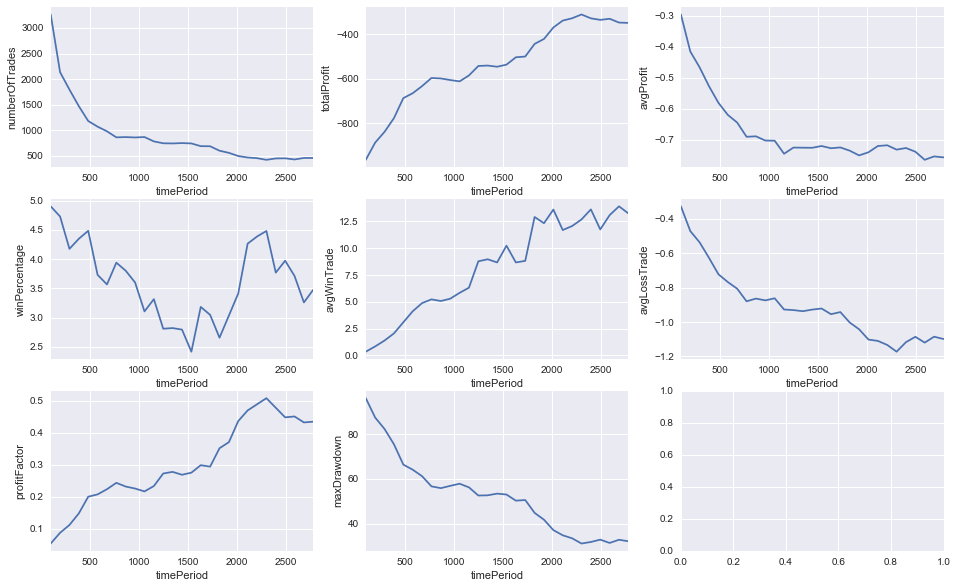

In [147]:
f, axarr = plt.subplots(3, 3, figsize=[16,10])
sns.tsplot(data=allStats, time="timePeriod", value="numberOfTrades", ax=axarr[0, 0])
sns.tsplot(data=allStats, time="timePeriod", value="totalProfit", ax=axarr[0, 1]);
sns.tsplot(data=allStats, time="timePeriod", value="avgProfit", ax=axarr[0, 2]);
sns.tsplot(data=allStats, time="timePeriod", value="winPercentage", ax=axarr[1, 0]);
sns.tsplot(data=allStats, time="timePeriod", value="avgWinTrade", ax=axarr[1, 1]);
sns.tsplot(data=allStats, time="timePeriod", value="avgLossTrade", ax=axarr[1, 2]);
sns.tsplot(data=allStats, time="timePeriod", value="profitFactor", ax=axarr[2, 0]);
sns.tsplot(data=allStats, time="timePeriod", value="maxDrawdown", ax=axarr[2, 1]);

# Conclusion

Strategie Simple moving average, je naprosto nevhodna pro tradovani btc-usd. Jelikoz negenerovala zisk s zadnym parametrem,
vidim ji, jako naprosto nepouzitelnou pro pristi experimenty.